## SVD-scipy로 대규모 추천시스템 만들어보기

### 데이터 정제

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import plotly.express as px

In [2]:
# 데이터 불러오기
rating_df = pd.read_csv('..\dataset\movie.data', sep='\t', header=None, names = ['userID', 'movieID', 'rating', 'timestamp'])[['userID', 'movieID', 'rating']]
movie_info_df = pd.read_csv('..\dataset\movie.item', sep='|', encoding='latin')
movie_info_df.columns = ['movieID' , 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Children' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western']

In [3]:
# 영화 정보와 평점 테이블을 merge. 지금 머지하는게 좋은 방법은 아니다.
movie_rating_df = pd.merge(rating_df, movie_info_df[['movieID', 'movie_title']], on = 'movieID')
movie_rating_df['rating']= movie_rating_df['rating'].astype(float)
movie_rating_df

,userID,movieID,rating,movie_title
0,196,242,3.0,Kolya (1996)
1,63,242,3.0,Kolya (1996)
2,226,242,5.0,Kolya (1996)
3,154,242,3.0,Kolya (1996)
4,306,242,5.0,Kolya (1996)
...,...,...,...,...
99543,840,1674,4.0,Mamma Roma (1962)
99544,655,1640,3.0,"Eighth Day, The (1996)"
99545,655,1637,3.0,Girls Town (1996)
99546,655,1630,3.0,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [4]:
# KNN 한거와 동일하게 index 만들어주고 user, movie 갯수 세고 (userid, movieid 기준으로 sort한다.)
user_ids = movie_rating_df["userID"].unique()
user2idx_dict = {x: i for i, x in enumerate(user_ids)}

movie_ids = movie_rating_df["movieID"].unique()
movie2idx_dict = {x: i for i, x in enumerate(movie_ids)}

movie_rating_df["user_idx"] = movie_rating_df["userID"].map(user2idx_dict)
movie_rating_df["movie_idx"] = movie_rating_df["movieID"].map(movie2idx_dict)

num_users = movie_rating_df["userID"].nunique()
num_movies = movie_rating_df["movieID"].nunique()
print(num_users, num_movies)

movie_rating_df = movie_rating_df.sort_values(['user_idx', 'movie_idx'])
movie_rating_df = movie_rating_df.reset_index(drop=True)
movie_rating_df

943 1681


,userID,movieID,rating,movie_title,user_idx,movie_idx
0,196,242,3.0,Kolya (1996),0,0
1,196,257,2.0,Men in Black (1997),0,10
2,196,111,4.0,"Truth About Cats & Dogs, The (1996)",0,82
3,196,25,4.0,"Birdcage, The (1996)",0,85
4,196,382,4.0,"Adventures of Priscilla, Queen of the Desert, ...",0,91
...,...,...,...,...,...,...
99543,873,313,5.0,Titanic (1997),942,718
99544,873,326,4.0,G.I. Jane (1997),942,859
99545,873,348,3.0,Desperate Measures (1998),942,958
99546,873,358,2.0,Spawn (1997),942,1022


In [15]:
# train, validation, test dataset 나눈다
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(movie_rating_df, test_size=0.1, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [12]:
# sparse matrix로 만든다. 뭘로 압축해야될지는 상황에 따라 다르다.
# 진짜 대규모가 아니면 시간 차이는 많이 나지 않는다.
from scipy.sparse import coo_matrix, linalg

rating_sparse_arr = coo_matrix((train_df['rating'],
                                (train_df['user_idx'],
                                 train_df['movie_idx'])),
                               shape = (num_users, num_movies))
rating_sparse_arr

<943x1681 sparse matrix of type '<class 'numpy.float64'>'
	with 89593 stored elements in COOrdinate format>

### 모델 빌드(행렬 분해)

일반 Truncated SVD는 skearn의 decomposition(행렬 분해)에 들어있습니다.     
그러나 우리가 사용하는 sparse matrix를 처리하기 위해서는 scipy.sparse안에 linalg의 svds를 써야 합니다.    
svd는 우리가 익숙한 형태(fit)로 사용할 수 있지만 svds는 약간 사용법이 다릅니다.


- SVD : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
- SVDs : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html
- sparse linalg : https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html

In [91]:
# 행렬 분해, U, S, V는 ndarray
from scipy.sparse import linalg
U, S, V = linalg.svds(rating_sparse_arr, k = 30)

In [92]:
# sigma 행렬은 k*k인데 대각행렬이니까 값이 있는 대각 성분만 리턴해준다
print(U.shape, S.shape, V.shape)

(943, 30) (30,) (30, 1681)


원래 등록된 평점 vector --> 잠재적인 취향을 추론
- 추천하려면 분해한 행렬 다시 복원 필요. scipy에서 행렬곱 연산자는 @
- S는 대각행렬의 대각 성분이니까 대각행렬로 만들어야 한다.
- 모든 유저를 계산하지 않고 한명만 계산하고 싶다.

In [104]:
target_user_idx = 20
pred = U[target_user_idx] @ np.diag(S) @ V
pred

array([ 1.22996911,  2.85146369, -0.01350261, ..., -0.05765298,
       -0.05765298, -0.05765298])

### 추천 방법
복원된 평점 vector를 크기 순서대로 정렬하여 영화 index를 추천(본 영화 빼고)

eg. argsort, pandas sort_values

### 성능평가

Train data의 오차 확인 -> 복원이 잘 되었는지 파악

In [105]:
target_tr_df = train_df[train_df['user_idx'] == target_user_idx]
target_tr_df['pred'] = pred[target_tr_df['movie_idx'].to_list()]
target_tr_df = target_tr_df[['user_idx', 'movie_idx', 'rating', 'pred']]
target_tr_df['error'] = target_tr_df['rating'] - target_tr_df['pred']
target_tr_df

C:\Users\User\AppData\Local\Temp\ipykernel_11152\3541936503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_tr_df['pred'] = pred[target_tr_df['movie_idx'].to_list()]


,user_idx,movie_idx,rating,pred,error
2516,20,388,3.0,1.194794,1.805206
2504,20,238,4.0,2.142759,1.857241
2494,20,124,2.0,0.192586,1.807414
2511,20,336,5.0,0.861060,4.138940
2550,20,1150,4.0,0.051388,3.948612
2515,20,379,5.0,1.305964,3.694036
2490,20,39,5.0,0.916522,4.083478
2503,20,237,2.0,0.137272,1.862728
2499,20,208,4.0,1.396152,2.603848
2498,20,194,3.0,0.184481,2.815519


test data에서 확인

In [106]:
target_te_df = test_df[test_df['user_idx'] == target_user_idx]
target_te_df['pred'] = pred[target_te_df['movie_idx'].to_list()]
target_te_df = target_te_df[['user_idx', 'movie_idx', 'rating', 'pred']]
target_te_df['error'] = target_te_df['rating'] - target_te_df['pred']
target_te_df

C:\Users\User\AppData\Local\Temp\ipykernel_11152\1347289472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_te_df['pred'] = pred[target_te_df['movie_idx'].to_list()]


,user_idx,movie_idx,rating,pred,error
2493,20,107,3.0,0.420637,2.579363
2513,20,354,3.0,0.194361,2.805639
2514,20,355,4.0,0.605378,3.394622
2527,20,570,5.0,1.020781,3.979219
2547,20,1015,4.0,0.580811,3.419189
2540,20,872,4.0,1.210951,2.789049
2542,20,912,3.0,0.137883,2.862117
2544,20,938,3.0,0.300018,2.699982
2502,20,234,4.0,0.210809,3.789191
2495,20,138,5.0,1.096371,3.903629


k = 600으로 했을 때 train은 에러가 적은데 test는 에러가 크다. 왜?   
k가 크면 복원이 잘되는건데, test data는 train data에 없었으니까 전부 0으로 학습되었을거다.   
--> 0을 0으로 잘 복원하는것!

In [107]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(target_te_df['rating'], target_te_df['pred'].to_list())
RMSE = math.sqrt(MSE)
RMSE 


3.262359732609724

SVD는 Top k 추천을 위한 분류. 회귀가 아님!!   
복원을 잘 하는게 아니라 순서를 얼마나 잘 맞추는가를 측정하는게 중요하다.   
surprise에서는 잘 복원되는데 그게 이상한거.

몇점 이상이 그사람의 취향인지 기준을 정하고,   
상위 몇 개 중 그 사람이 취향이 몇개나 있다고 예측했는지를 봐야 한다.

In [110]:
target_te_df['rating_bool'] = target_te_df['rating'].apply(lambda x : 1 if x > 3 else 0)
target_te_df

,user_idx,movie_idx,rating,pred,error,rating_bool
2493,20,107,3.0,0.420637,2.579363,0
2513,20,354,3.0,0.194361,2.805639,0
2514,20,355,4.0,0.605378,3.394622,1
2527,20,570,5.0,1.020781,3.979219,1
2547,20,1015,4.0,0.580811,3.419189,1
2540,20,872,4.0,1.210951,2.789049,1
2542,20,912,3.0,0.137883,2.862117,0
2544,20,938,3.0,0.300018,2.699982,0
2502,20,234,4.0,0.210809,3.789191,1
2495,20,138,5.0,1.096371,3.903629,1


In [113]:
target_te_df = target_te_df.sort_values('pred', ascending = False)

In [114]:
top_k = 3
target_te_df['rating_bool'].iloc[:top_k].mean()

1.0

## 모든 유저에 대해 동일한 작업 해보기

In [ ]:
all_top_k = []
top_k = 3
result_df = pd.DataFrame(data = None, columns = ['user_idx', 'movie_idx', 'rating', 'pred', 'error', 'rating_bool'])


U, S, V = linalg.svds(rating_sparse_arr, k = 50) 

for target_user_idx in range(num_users):
    # 추론
    pred = U[target_user_idx] @ np.diag(S) @ V
    
    # target_df 만들기
    target_te_df = test_df[test_df['user_idx'] == target_user_idx]
    target_te_df['pred'] = pred[target_te_df['movie_idx'].to_list()]
    target_te_df = target_te_df[['user_idx', 'movie_idx', 'rating', 'pred']]
    target_te_df['error'] = target_te_df['rating'] - target_te_df['pred']
    
    # rating_bool 만들기
    target_te_df['rating_bool'] = target_te_df['rating'].apply(lambda x : 1 if x > 3 else 0)
    
    # 정렬
    target_te_df = target_te_df.sort_values('pred', ascending = False)
    result_df = pd.concat([result_df, target_te_df])
    
    # topk 확인
    top_k_score = target_te_df['rating_bool'].iloc[:top_k].mean()
    all_top_k.append(top_k_score)

In [137]:
px.violin(result_df, x = 'rating', y = 'pred', box = True)

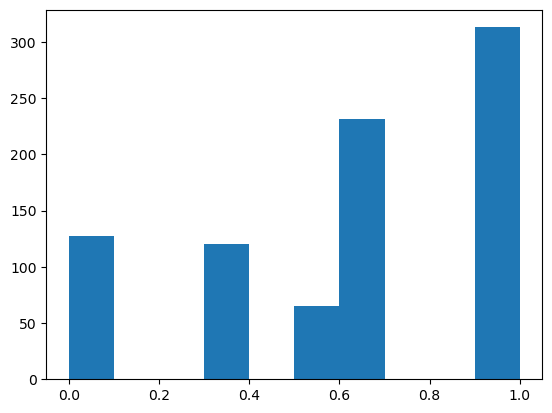

In [138]:
plt.hist(all_top_k)
plt.show()

## Latent Space 크기에 따른 비교

In [139]:
import warnings
warnings.filterwarnings("ignore")

In [150]:
import math
##### 14 0.6427180685358255

for latent_dim in range(10,20):
    U, S, V = linalg.svds(rating_sparse_arr, k = latent_dim) 

    all_top_k = []
    result_df = pd.DataFrame(data = None, columns = ['user_idx', 'movie_idx', 'rating', 'pred', 'error', 'rating_bool'])
    top_k = 3
    for target_user_idx in range(num_users):
        # 추론
        pred = U[target_user_idx] @ np.diag(S) @ V
        
        # target_df 만들기
        target_te_df = test_df[test_df['user_idx'] == target_user_idx]
        target_te_df['pred'] = pred[target_te_df['movie_idx'].to_list()]
        target_te_df = target_te_df[['user_idx', 'movie_idx', 'rating', 'pred']]
        target_te_df['error'] = target_te_df['rating'] - target_te_df['pred']
        
        # rating_bool 만들기
        target_te_df['rating_bool'] = target_te_df['rating'].apply(lambda x : 1 if x > 3 else 0)
        
        # 정렬
        target_te_df = target_te_df.sort_values('pred', ascending = False)
        result_df = pd.concat([result_df, target_te_df])
        
        # topk 확인
        top_k_score = target_te_df['rating_bool'].iloc[:top_k].mean()
        if False == math.isnan(top_k_score):
            all_top_k.append(top_k_score)
    
    print(latent_dim, np.mean(all_top_k))
  
# 1 0.6376557632398753
# 10 0.6415498442367601
##### 14 0.6427180685358255
# 20 0.6442757009345794
# 30 0.6399922118380061
# 40 0.6372663551401869
# 50 0.6302570093457944
# 60 0.6244158878504673
# 70 0.621690031152648
# 80 0.6177959501557633
# 90 0.6170171339563864
# 100 0.6142912772585669
# 110 0.6107866043613708

10 0.6415498442367601
11 0.6415498442367601
12 0.6411604361370715
13 0.642328660436137
14 0.6427180685358255
15 0.6415498442367602
16 0.6423286604361371
17 0.642328660436137
18 0.6419392523364486
19 0.6415498442367602


SVC는 머신러닝같은 아이. 
- rating을 scaling 해서 결과가 달라지는지 테스트 해보자.
- 개인의 편향을 고려해서 계산해보자.
    - 전체 유저 평균을 빼고 모델 만들어서 추론할 때 타겟 유저의 평균을 더한다.
- top k 말고 nDCG를 sklearn, numpy, torch, tensorflow 등등에서 찾아서 평가해보자.

### nDCG 적용

In [ ]:
import math

for latent_dim in range(10,20):
    U, S, V = linalg.svds(rating_sparse_arr, k = latent_dim) 

    all_top_k = []
    result_df = pd.DataFrame(data = None, columns = ['user_idx', 'movie_idx', 'rating', 'pred', 'error', 'rating_bool'])
    top_k = 3
    for target_user_idx in range(num_users):
        # 추론
        pred = U[target_user_idx] @ np.diag(S) @ V
        
        # target_df 만들기
        target_te_df = test_df[test_df['user_idx'] == target_user_idx][['user_idx', 'movie_idx', 'rating']]
        
        # rating_bool 만들기
        target_te_df['rating_bool'] = target_te_df['rating'].apply(lambda x : 1 if x > 3 else 0)
        
        # 정렬
        target_te_df = target_te_df.sort_values('pred', ascending = False)
        result_df = pd.concat([result_df, target_te_df])
        
        # topk 확인
        top_k_score = target_te_df['rating_bool'].iloc[:top_k].mean()
        if False == math.isnan(top_k_score):
            all_top_k.append(top_k_score)
    
    print(latent_dim, np.mean(all_top_k))

In [151]:
result_df

,user_idx,movie_idx,rating,pred,error,rating_bool
23,0,490,3.0,1.472185,1.527815,0
87,1,354,4.0,2.393652,1.606348,1
97,1,405,3.0,1.047874,1.952126,0
102,1,486,3.0,0.773948,2.226052,0
114,1,671,5.0,0.720509,4.279491,1
...,...,...,...,...,...,...
99434,939,95,2.0,0.034269,1.965731,0
99479,940,156,2.0,1.580432,0.419568,0
99514,941,407,5.0,0.212177,4.787823,1
99539,942,419,5.0,0.607071,4.392929,1


In [152]:
target_te_df = test_df[test_df['user_idx'] == target_user_idx][['user_idx', 'movie_idx', 'rating']]
target_te_df

,user_idx,movie_idx,rating
99539,942,419,5.0
99534,942,250,1.0
